In [1]:
import arrow
import datetime
import matplotlib.pyplot as plt
import netCDF4 as nc
import numpy as np
import os
import pandas as pd
import pickle
import xarray as xr

%matplotlib inline

## The Grid ##

In [2]:
mesh = nc.Dataset('/home/sallen/MEOPAR/grid/mesh_mask201702.nc')
#mesh = nc.Dataset('../../../myResults/mesh_mask201702.nc')
gdepw = mesh.variables['gdepw_1d'][0]
bathy = nc.Dataset('/home/sallen/MEOPAR/grid/bathymetry_201702.nc')
#bathy = nc.Dataset('../../../myResults/bathymetry_201702.nc')
lats = bathy.variables['nav_lat'][:]
lons = bathy.variables['nav_lon'][:]
mesh.close()
bathy.close()

## Functions ##

In [3]:
def calculate_transport(basedir, dir1, section):
    filename = 'ariane_positions_quantitative.nc'
    with nc.Dataset(os.path.join('/data/sallen/results/Ariane',basedir, dir1, filename)) as dataset:
        final_section = dataset.variables['final_section'][:]
        final_transport = dataset.variables['final_transp'][:]
        vic_transport = np.sum(np.where(final_section == section, final_transport, 0))
    return (vic_transport/24.)

In [4]:
def calculate_all(basedir, dir1, section, allv, loop=None):
    final = {}
    mean = {}    
    filename = 'ariane_positions_quantitative.nc'
    fullfile = os.path.join('/data/sallen/results/Ariane',basedir, dir1, filename)
    try:
        if os.stat(fullfile).st_size > 0:
            filegood = True
            with nc.Dataset(fullfile) as dataset:
                final_section = dataset.variables['final_section'][:]
                final_transport = dataset.variables['final_transp'][:]
                final_age = dataset.variables['final_age'][:]
                if loop == None:
                    vic_transport = np.sum(np.where(final_section == section, final_transport, 0))
                elif loop == 'Short':
                    vic_transport = np.sum(np.where((final_section == section) & (final_age <= 24*3600), final_transport, 0))
                elif loop == 'Long':
                    vic_transport = np.sum(np.where((final_section == section) & (final_age > 24*3600), final_transport, 0))
                for variable in allv:
                    if variable == 'final_age':
                        scale = 86400. # convert from seconds to days
                    else:
                        scale = 1.
                    final[variable] = dataset.variables[variable][:]/scale
                    if loop == None:
                        mean[variable] = np.sum(np.where(final_section == section, final_transport*final[variable], 0))/vic_transport
                    elif loop == 'Short':
                        mean[variable] = np.sum(np.where((final_section == section) & (final_age <= 24*3600), 
                                                         final_transport*final[variable], 0))/vic_transport
                    elif loop == 'Long':
                        mean[variable] = np.sum(np.where((final_section == section) & (final_age > 24*3600), 
                                                         final_transport*final[variable], 0))/vic_transport
                
        else:
            filegood = False
            vic_transport = float('NaN')
            print ("empty file", dir1)
    except OSError:
        filegood = False
        vic_transport = float('NaN')
        print ('Missing Data', dir1)
    return filegood, vic_transport/24., mean

In [5]:
def get_data(start, endtime, basedir, section):
    transport = np.zeros(365*2+1)
    timerange = arrow.Arrow.range('day', start, endtime)
    time = []
    for i, r in enumerate(timerange):
        dir1 = r.format('DDMMMYY').lower()
        transport[i] = calculate_transport(basedir, dir1, section)
        transport[i] = calculate_transport('./', './', section)
        time.append(r.datetime)
    return time, transport[:len(timerange)]  

In [6]:
def get_data_all(start, endtime, basedir, section, allv, loop=None):
    timerange = arrow.Arrow.range('day', start, endtime)
    length = (endtime-start).days + 1
    transport = np.zeros(length)
    mean = {}
    for variable in allv:
        mean[variable] = np.zeros(length)
    time = []
    for i, r in enumerate(timerange):
        dir1 = r.format('DDMMMYY').lower()
        filegood, transport[i], meanday = calculate_all(basedir, dir1, section, allv, loop)
        for variable in allv:
            if filegood:
                mean[variable][i] = meanday[variable]
            else:
                mean[variable][i] = float('NaN')
        time.append(r.datetime)
    return time, transport, mean

In [7]:
def save_position(basedir, dir1, section, fi, ff):
    print(fi, ff)
    filename = 'ariane_positions_quantitative.nc'
    with nc.Dataset(os.path.join('/data/sallen/results/Ariane',basedir, dir1, filename)) as dataset:
        final_section = dataset.variables['final_section'][:]
        final_transport = dataset.variables['final_transp'][:]
        final_depth = dataset.variables['final_depth'][:]
        final_lon = dataset.variables['final_lon'][:]
        final_lat = dataset.variables['final_lat'][:]
        init_depth = dataset.variables['init_depth'][:]
        init_lat = dataset.variables['init_lat'][:]
        init_lon = dataset.variables['init_lon'][:]
        for part in range(final_section.shape[0]):
            if final_section[part] == section:
                fi.write('{0:4f} {1:4f} {2:4f} {3:4f} \n'.format(
                    init_depth[part], init_lat[part], init_lon[part], final_transport[part]))
                ff.write('{0:4f} {1:4f} {2:4f} {3:4f} \n'.format(
                    final_depth[part], final_lat[part], final_lon[part], final_transport[part]))
    

## Get the Data ##

### Meanders ###

In [9]:
years = [2015, 2016, 2017, 2018]

In [9]:
one_case = xr.open_dataset('/data/sallen/results/Ariane/FullSouth/01nov15/ariane_positions_quantitative.nc')
one_case

<xarray.Dataset>
Dimensions:        (ntraj: 40842)
Dimensions without coordinates: ntraj
Data variables: (12/25)
    init_x         (ntraj) float64 ...
    init_y         (ntraj) float64 ...
    init_z         (ntraj) float64 ...
    init_t         (ntraj) float64 ...
    init_age       (ntraj) timedelta64[ns] ...
    init_transp    (ntraj) float64 ...
    ...             ...
    init_lon       (ntraj) float64 ...
    init_lat       (ntraj) float64 ...
    init_depth     (ntraj) float64 ...
    final_lon      (ntraj) float64 ...
    final_lat      (ntraj) float64 ...
    final_depth    (ntraj) float64 ...
Attributes: (12/105)
    key_roms:                  .FALSE.
    key_symphonie:             .FALSE.
    key_B2C_grid:              .FALSE.
    key_sequential:            .TRUE.
    key_alltracers:            .TRUE.
    key_ascii_outputs:         .TRUE.
    ...                        ...
    ind0_sa:                   1
    indn_sa:                   30
    maxsize_sa:                2
    c_suffix_sa:               _grid_T.nc
    nc_var_sa:                 vosaline
    nc_att_mask_sa:            NONE

In [12]:
print ((one_case.init_transp - one_case.final_transp).sum())

<xarray.DataArray ()>
array(0.)


In [57]:
for ii in range(7300):
    if np.isnan(one_case.final_section[ii]):
        print (ii, one_case.final_section[ii].values)
print (one_case.final_section[7287].values)

7287 nan
nan


(0.0, 24.0)

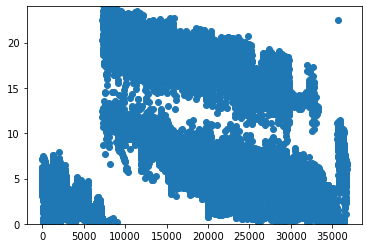

In [40]:
#plt.hist((one_case.final_age[one_case.final_section == 0].values/1e9/3600))
plt.plot(one_case.final_age[one_case.final_section == 0].values/np.timedelta64(1, 'h'), 'o')
plt.ylim(0, 24)

In [50]:
myvalues = (one_case.final_age[one_case.final_section == 0].values/np.timedelta64(1, 'h'))
sortvalues= np.sort(myvalues)

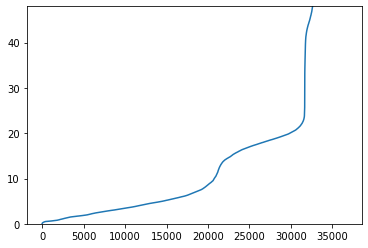

In [53]:
plt.plot(sortvalues)
plt.ylim(0, 48);

Victoria Sill Meanders

In [12]:
# Full South Vic Meanders
year = 2015
allv = ['final_age', 'final_depth', 'final_salt', 'final_temp', 'final_lon', 
        'init_depth', 'init_salt', 'init_temp', 'init_lat']
start = datetime.datetime(year, 1, 1)
endtime = datetime.datetime(year, 12, 31)
time, transport, mean = get_data_all(start, endtime, 'FullSouth', 0, allv)
fullsouth_all = pd.DataFrame(data=transport, index=time, columns=['transport'])
for variable in allv:
    fullsouth_all = fullsouth_all.assign(mycol=pd.Series(mean[variable]).values)
    fullsouth_all.rename(columns={'mycol':variable}, inplace=True)
fullsouth_all
fullsouth_all.to_csv('Vic_meanders_'+str(year)+'_v3.csv')

<ipython-input-4-4ab44c4032cd>:18: UserWarning: WARNING: missing_value not used since it
cannot be safely cast to variable data type
  final[variable] = dataset.variables[variable][:]/scale


In [60]:
# Full South Vic Tidal Pumping
for year in years:
    allv = ['final_age', 'final_depth', 'final_salt', 'final_temp', 'final_lon', 
            'init_depth', 'init_salt', 'init_temp', 'init_lat']
    start = datetime.datetime(year, 1, 1)
    endtime = datetime.datetime(year, 12, 31)
    time, transport, mean = get_data_all(start, endtime, 'FullSouth', 0, allv, loop='Short')
    fullsouth_all = pd.DataFrame(data=transport, index=time, columns=['transport'])
    for variable in allv:
        fullsouth_all = fullsouth_all.assign(mycol=pd.Series(mean[variable]).values)
        fullsouth_all.rename(columns={'mycol':variable}, inplace=True)
    fullsouth_all
    fullsouth_all.to_csv('Vic_tidalpump_'+str(year)+'_v3.csv')
    print (year)

<ipython-input-58-8c8f3492929a>:24: UserWarning: WARNING: missing_value not used since it
cannot be safely cast to variable data type
  final[variable] = dataset.variables[variable][:]/scale


2015
2016
2017
Missing Data 04sep18
2018


In [61]:
# Full South Vic Loops
for year in years:
    allv = ['final_age', 'final_depth', 'final_salt', 'final_temp', 'final_lon', 
            'init_depth', 'init_salt', 'init_temp', 'init_lat']
    start = datetime.datetime(year, 1, 1)
    endtime = datetime.datetime(year, 12, 31)
    time, transport, mean = get_data_all(start, endtime, 'FullSouth', 0, allv, loop='Long')
    fullsouth_all = pd.DataFrame(data=transport, index=time, columns=['transport'])
    for variable in allv:
        fullsouth_all = fullsouth_all.assign(mycol=pd.Series(mean[variable]).values)
        fullsouth_all.rename(columns={'mycol':variable}, inplace=True)
    fullsouth_all
    fullsouth_all.to_csv('Vic_loops_'+str(year)+'_v3.csv')
    print (year)

<ipython-input-58-8c8f3492929a>:24: UserWarning: WARNING: missing_value not used since it
cannot be safely cast to variable data type
  final[variable] = dataset.variables[variable][:]/scale


2015
2016
2017
Missing Data 04sep18
2018


In [17]:
# BackSouth Vic Meanders
year = 2015
allv = ['final_age', 'final_depth', 'final_salt', 'final_temp', 'final_lon', 
        'init_depth', 'init_salt', 'init_temp', 'init_lat']
start = datetime.datetime(year, 1, 1)
endtime = datetime.datetime(year, 12, 31)
time, transport, mean = get_data_all(start, endtime, 'BackSouth', 0, allv)
fullsouth_all = pd.DataFrame(data=transport, index=time, columns=['transport'])
for variable in allv:
    fullsouth_all = fullsouth_all.assign(mycol=pd.Series(mean[variable]).values)
    fullsouth_all.rename(columns={'mycol':variable}, inplace=True)
fullsouth_all.to_csv('Vic_back_meanders_'+str(year)+'_v3.csv')

<ipython-input-4-4ab44c4032cd>:18: UserWarning: WARNING: missing_value not used since it
cannot be safely cast to variable data type
  final[variable] = dataset.variables[variable][:]/scale


PR and GI together meanders

In [21]:
# Full North PR Meanders
year = 2015
allv = ['final_age', 'final_depth', 'final_salt', 'final_temp', 'final_lon', 
        'init_depth', 'init_salt', 'init_temp', 'init_lat']
start = datetime.datetime(year, 1, 1)
endtime = datetime.datetime(year, 12, 31)
time, transport, mean = get_data_all(start, endtime, 'FullNorth', 0, allv)
fullnorth_all = pd.DataFrame(data=transport, index=time, columns=['transport'])
for variable in allv:
    fullnorth_all = fullnorth_all.assign(mycol=pd.Series(mean[variable]).values)
    fullnorth_all.rename(columns={'mycol':variable}, inplace=True)
fullnorth_all
fullnorth_all.to_csv('PR_meanders_'+str(year)+'_v3.csv')

<ipython-input-4-4ab44c4032cd>:18: UserWarning: WARNING: missing_value not used since it
cannot be safely cast to variable data type
  final[variable] = dataset.variables[variable][:]/scale


In [10]:
# Full North PR Tidal Pumping
for year in years:
    allv = ['final_age', 'final_depth', 'final_salt', 'final_temp', 'final_lon', 
            'init_depth', 'init_salt', 'init_temp', 'init_lat']
    start = datetime.datetime(year, 1, 1)
    endtime = datetime.datetime(year, 12, 31)
    time, transport, mean = get_data_all(start, endtime, 'FullNorth', 0, allv, loop='Short')
    fullnorth_all = pd.DataFrame(data=transport, index=time, columns=['transport'])
    for variable in allv:
        fullnorth_all = fullnorth_all.assign(mycol=pd.Series(mean[variable]).values)
        fullnorth_all.rename(columns={'mycol':variable}, inplace=True)
    fullnorth_all.to_csv('PR_tidalpump_'+str(year)+'_v3.csv')
    print (year)

/tmp/ipykernel_1042277/2938400006.py:24: UserWarning: WARNING: missing_value not used since it
cannot be safely cast to variable data type
  final[variable] = dataset.variables[variable][:]/scale


2015


/tmp/ipykernel_1042277/2938400006.py:24: UserWarning: WARNING: missing_value not used since it
cannot be safely cast to variable data type
  final[variable] = dataset.variables[variable][:]/scale


2016


/tmp/ipykernel_1042277/2938400006.py:24: UserWarning: WARNING: missing_value not used since it
cannot be safely cast to variable data type
  final[variable] = dataset.variables[variable][:]/scale


Missing Data 12aug17
2017


/tmp/ipykernel_1042277/2938400006.py:24: UserWarning: WARNING: missing_value not used since it
cannot be safely cast to variable data type
  final[variable] = dataset.variables[variable][:]/scale


2018


In [11]:
# Full North PR Loops
for year in years:
    allv = ['final_age', 'final_depth', 'final_salt', 'final_temp', 'final_lon', 
            'init_depth', 'init_salt', 'init_temp', 'init_lat']
    start = datetime.datetime(year, 1, 1)
    endtime = datetime.datetime(year, 12, 31)
    time, transport, mean = get_data_all(start, endtime, 'FullNorth', 0, allv, loop='Long')
    fullnorth_all = pd.DataFrame(data=transport, index=time, columns=['transport'])
    for variable in allv:
        fullnorth_all = fullnorth_all.assign(mycol=pd.Series(mean[variable]).values)
        fullnorth_all.rename(columns={'mycol':variable}, inplace=True)
    fullnorth_all.to_csv('PR_loops_'+str(year)+'_v3.csv')
    print (year)

/tmp/ipykernel_1042277/2938400006.py:24: UserWarning: WARNING: missing_value not used since it
cannot be safely cast to variable data type
  final[variable] = dataset.variables[variable][:]/scale


2015


/tmp/ipykernel_1042277/2938400006.py:24: UserWarning: WARNING: missing_value not used since it
cannot be safely cast to variable data type
  final[variable] = dataset.variables[variable][:]/scale


2016


/tmp/ipykernel_1042277/2938400006.py:24: UserWarning: WARNING: missing_value not used since it
cannot be safely cast to variable data type
  final[variable] = dataset.variables[variable][:]/scale


Missing Data 12aug17
2017


/tmp/ipykernel_1042277/2938400006.py:24: UserWarning: WARNING: missing_value not used since it
cannot be safely cast to variable data type
  final[variable] = dataset.variables[variable][:]/scale


2018


In [24]:
# Full North PR -> GI Meanders
for year in years:
    allv = ['final_age', 'final_depth', 'final_salt', 'final_temp', 'final_lon', 
            'init_depth', 'init_salt', 'init_temp', 'init_lat']
    start = datetime.datetime(year, 1, 1)
    endtime = datetime.datetime(year, 12, 31)
    time, transport, mean = get_data_all(start, endtime, 'FullNorth', 3, allv)
    fullnorth_all = pd.DataFrame(data=transport, index=time, columns=['transport'])
    for variable in allv:
        fullnorth_all = fullnorth_all.assign(mycol=pd.Series(mean[variable]).values)
        fullnorth_all.rename(columns={'mycol':variable}, inplace=True)
    fullnorth_all
    fullnorth_all.to_csv('PR_to_GI_meanders_'+str(year)+'_v3.csv')

<ipython-input-4-4ab44c4032cd>:18: UserWarning: WARNING: missing_value not used since it
cannot be safely cast to variable data type
  final[variable] = dataset.variables[variable][:]/scale


Missing Data 12aug17


In [12]:
# Full North PR -> GI Tidal Pumping
for year in years:
    allv = ['final_age', 'final_depth', 'final_salt', 'final_temp', 'final_lon', 
            'init_depth', 'init_salt', 'init_temp', 'init_lat']
    start = datetime.datetime(year, 1, 1)
    endtime = datetime.datetime(year, 12, 31)
    time, transport, mean = get_data_all(start, endtime, 'FullNorth', 3, allv, loop='Short')
    fullnorth_all = pd.DataFrame(data=transport, index=time, columns=['transport'])
    for variable in allv:
        fullnorth_all = fullnorth_all.assign(mycol=pd.Series(mean[variable]).values)
        fullnorth_all.rename(columns={'mycol':variable}, inplace=True)
    fullnorth_all.to_csv('PR_to_GI_tidalpump_'+str(year)+'_v3.csv')
    print (year)

/tmp/ipykernel_1042277/2938400006.py:24: UserWarning: WARNING: missing_value not used since it
cannot be safely cast to variable data type
  final[variable] = dataset.variables[variable][:]/scale


2015


/tmp/ipykernel_1042277/2938400006.py:24: UserWarning: WARNING: missing_value not used since it
cannot be safely cast to variable data type
  final[variable] = dataset.variables[variable][:]/scale


2016


/tmp/ipykernel_1042277/2938400006.py:24: UserWarning: WARNING: missing_value not used since it
cannot be safely cast to variable data type
  final[variable] = dataset.variables[variable][:]/scale


Missing Data 12aug17
2017


/tmp/ipykernel_1042277/2938400006.py:24: UserWarning: WARNING: missing_value not used since it
cannot be safely cast to variable data type
  final[variable] = dataset.variables[variable][:]/scale


2018


In [13]:
# Full North PR -> GI Tidal Pumping
for year in years:
    allv = ['final_age', 'final_depth', 'final_salt', 'final_temp', 'final_lon', 
            'init_depth', 'init_salt', 'init_temp', 'init_lat']
    start = datetime.datetime(year, 1, 1)
    endtime = datetime.datetime(year, 12, 31)
    time, transport, mean = get_data_all(start, endtime, 'FullNorth', 3, allv, loop='Long')
    fullnorth_all = pd.DataFrame(data=transport, index=time, columns=['transport'])
    for variable in allv:
        fullnorth_all = fullnorth_all.assign(mycol=pd.Series(mean[variable]).values)
        fullnorth_all.rename(columns={'mycol':variable}, inplace=True)
    fullnorth_all.to_csv('PR_to_GI_loops_'+str(year)+'_v3.csv')
    print (year)

/tmp/ipykernel_1042277/2938400006.py:24: UserWarning: WARNING: missing_value not used since it
cannot be safely cast to variable data type
  final[variable] = dataset.variables[variable][:]/scale


2015


/tmp/ipykernel_1042277/2938400006.py:24: UserWarning: WARNING: missing_value not used since it
cannot be safely cast to variable data type
  final[variable] = dataset.variables[variable][:]/scale


2016


/tmp/ipykernel_1042277/2938400006.py:24: UserWarning: WARNING: missing_value not used since it
cannot be safely cast to variable data type
  final[variable] = dataset.variables[variable][:]/scale


Missing Data 12aug17
2017


/tmp/ipykernel_1042277/2938400006.py:24: UserWarning: WARNING: missing_value not used since it
cannot be safely cast to variable data type
  final[variable] = dataset.variables[variable][:]/scale


2018


In [30]:
# South G Islands GI meanders
for year in years:
    allv = ['final_age', 'final_depth', 'final_salt', 'final_temp', 'final_lon', 
            'init_depth', 'init_salt', 'init_temp', 'init_lat']
    start = datetime.datetime(year, 1, 1)
    endtime = datetime.datetime(year, 12, 31)
    time, transport, mean = get_data_all(start, endtime, 'SouthGIslands', 0, allv)
    fullsouth_all = pd.DataFrame(data=transport, index=time, columns=['transport'])
    for variable in allv:
        fullsouth_all = fullsouth_all.assign(mycol=pd.Series(mean[variable]).values)
        fullsouth_all.rename(columns={'mycol':variable}, inplace=True)
    fullsouth_all
    fullsouth_all.to_csv('GI_meanders_'+str(year)+'_v3.csv')

<ipython-input-4-4ab44c4032cd>:18: UserWarning: WARNING: missing_value not used since it
cannot be safely cast to variable data type
  final[variable] = dataset.variables[variable][:]/scale


Missing Data 20aug17


In [14]:
# South G Islands Tidal Pumping
for year in years:
    allv = ['final_age', 'final_depth', 'final_salt', 'final_temp', 'final_lon', 
            'init_depth', 'init_salt', 'init_temp', 'init_lat']
    start = datetime.datetime(year, 1, 1)
    endtime = datetime.datetime(year, 12, 31)
    time, transport, mean = get_data_all(start, endtime, 'SouthGIslands', 0, allv, loop='Short')
    fullsouth_all = pd.DataFrame(data=transport, index=time, columns=['transport'])
    for variable in allv:
        fullsouth_all = fullsouth_all.assign(mycol=pd.Series(mean[variable]).values)
        fullsouth_all.rename(columns={'mycol':variable}, inplace=True)
    fullsouth_all.to_csv('GI_tidalpump_'+str(year)+'_v3.csv')
    print (year)

/tmp/ipykernel_1042277/2938400006.py:24: UserWarning: WARNING: missing_value not used since it
cannot be safely cast to variable data type
  final[variable] = dataset.variables[variable][:]/scale


2015


/tmp/ipykernel_1042277/2938400006.py:24: UserWarning: WARNING: missing_value not used since it
cannot be safely cast to variable data type
  final[variable] = dataset.variables[variable][:]/scale


2016


/tmp/ipykernel_1042277/2938400006.py:24: UserWarning: WARNING: missing_value not used since it
cannot be safely cast to variable data type
  final[variable] = dataset.variables[variable][:]/scale


Missing Data 20aug17
2017


/tmp/ipykernel_1042277/2938400006.py:24: UserWarning: WARNING: missing_value not used since it
cannot be safely cast to variable data type
  final[variable] = dataset.variables[variable][:]/scale


2018


In [15]:
# South G Islands Loops
for year in years:
    allv = ['final_age', 'final_depth', 'final_salt', 'final_temp', 'final_lon', 
            'init_depth', 'init_salt', 'init_temp', 'init_lat']
    start = datetime.datetime(year, 1, 1)
    endtime = datetime.datetime(year, 12, 31)
    time, transport, mean = get_data_all(start, endtime, 'SouthGIslands', 0, allv, loop='Long')
    fullsouth_all = pd.DataFrame(data=transport, index=time, columns=['transport'])
    for variable in allv:
        fullsouth_all = fullsouth_all.assign(mycol=pd.Series(mean[variable]).values)
        fullsouth_all.rename(columns={'mycol':variable}, inplace=True)
    fullsouth_all.to_csv('GI_loops_'+str(year)+'_v3.csv')
    print (year)

/tmp/ipykernel_1042277/2938400006.py:24: UserWarning: WARNING: missing_value not used since it
cannot be safely cast to variable data type
  final[variable] = dataset.variables[variable][:]/scale


2015


/tmp/ipykernel_1042277/2938400006.py:24: UserWarning: WARNING: missing_value not used since it
cannot be safely cast to variable data type
  final[variable] = dataset.variables[variable][:]/scale


2016


/tmp/ipykernel_1042277/2938400006.py:24: UserWarning: WARNING: missing_value not used since it
cannot be safely cast to variable data type
  final[variable] = dataset.variables[variable][:]/scale


Missing Data 20aug17
2017


/tmp/ipykernel_1042277/2938400006.py:24: UserWarning: WARNING: missing_value not used since it
cannot be safely cast to variable data type
  final[variable] = dataset.variables[variable][:]/scale


2018


In [31]:
# South G Islands GI -> PR meanders
for year in years:
    allv = ['final_age', 'final_depth', 'final_salt', 'final_temp', 'final_lon', 
            'init_depth', 'init_salt', 'init_temp', 'init_lat']
    start = datetime.datetime(year, 1, 1)
    endtime = datetime.datetime(year, 12, 31)
    time, transport, mean = get_data_all(start, endtime, 'SouthGIslands', 3, allv)
    fullsouth_all = pd.DataFrame(data=transport, index=time, columns=['transport'])
    for variable in allv:
        fullsouth_all = fullsouth_all.assign(mycol=pd.Series(mean[variable]).values)
        fullsouth_all.rename(columns={'mycol':variable}, inplace=True)
    fullsouth_all
    fullsouth_all.to_csv('GI_to_PR_meanders_'+str(year)+'_v3.csv')

<ipython-input-4-4ab44c4032cd>:18: UserWarning: WARNING: missing_value not used since it
cannot be safely cast to variable data type
  final[variable] = dataset.variables[variable][:]/scale


Missing Data 20aug17


In [16]:
# South G Islands -> PR Tidal Pumping
for year in years:
    allv = ['final_age', 'final_depth', 'final_salt', 'final_temp', 'final_lon', 
            'init_depth', 'init_salt', 'init_temp', 'init_lat']
    start = datetime.datetime(year, 1, 1)
    endtime = datetime.datetime(year, 12, 31)
    time, transport, mean = get_data_all(start, endtime, 'SouthGIslands', 3, allv, loop='Short')
    fullsouth_all = pd.DataFrame(data=transport, index=time, columns=['transport'])
    for variable in allv:
        fullsouth_all = fullsouth_all.assign(mycol=pd.Series(mean[variable]).values)
        fullsouth_all.rename(columns={'mycol':variable}, inplace=True)
    fullsouth_all.to_csv('GI_to_PR_tidalpump_'+str(year)+'_v3.csv')
    print (year)

/tmp/ipykernel_1042277/2938400006.py:24: UserWarning: WARNING: missing_value not used since it
cannot be safely cast to variable data type
  final[variable] = dataset.variables[variable][:]/scale


2015


/tmp/ipykernel_1042277/2938400006.py:24: UserWarning: WARNING: missing_value not used since it
cannot be safely cast to variable data type
  final[variable] = dataset.variables[variable][:]/scale
/tmp/ipykernel_1042277/2938400006.py:28: RuntimeWarning: invalid value encountered in scalar divide
  mean[variable] = np.sum(np.where((final_section == section) & (final_age <= 24*3600),


2016


/tmp/ipykernel_1042277/2938400006.py:24: UserWarning: WARNING: missing_value not used since it
cannot be safely cast to variable data type
  final[variable] = dataset.variables[variable][:]/scale


Missing Data 20aug17
2017


/tmp/ipykernel_1042277/2938400006.py:24: UserWarning: WARNING: missing_value not used since it
cannot be safely cast to variable data type
  final[variable] = dataset.variables[variable][:]/scale


2018


In [17]:
# South G Islands -> PR Tidal Pumping
for year in years:
    allv = ['final_age', 'final_depth', 'final_salt', 'final_temp', 'final_lon', 
            'init_depth', 'init_salt', 'init_temp', 'init_lat']
    start = datetime.datetime(year, 1, 1)
    endtime = datetime.datetime(year, 12, 31)
    time, transport, mean = get_data_all(start, endtime, 'SouthGIslands', 3, allv, loop='Long')
    fullsouth_all = pd.DataFrame(data=transport, index=time, columns=['transport'])
    for variable in allv:
        fullsouth_all = fullsouth_all.assign(mycol=pd.Series(mean[variable]).values)
        fullsouth_all.rename(columns={'mycol':variable}, inplace=True)
    fullsouth_all.to_csv('GI_to_PR_loops_'+str(year)+'_v3.csv')
    print (year)

/tmp/ipykernel_1042277/2938400006.py:24: UserWarning: WARNING: missing_value not used since it
cannot be safely cast to variable data type
  final[variable] = dataset.variables[variable][:]/scale


2015


/tmp/ipykernel_1042277/2938400006.py:24: UserWarning: WARNING: missing_value not used since it
cannot be safely cast to variable data type
  final[variable] = dataset.variables[variable][:]/scale


2016


/tmp/ipykernel_1042277/2938400006.py:24: UserWarning: WARNING: missing_value not used since it
cannot be safely cast to variable data type
  final[variable] = dataset.variables[variable][:]/scale


Missing Data 20aug17
2017


/tmp/ipykernel_1042277/2938400006.py:24: UserWarning: WARNING: missing_value not used since it
cannot be safely cast to variable data type
  final[variable] = dataset.variables[variable][:]/scale


2018


In [25]:
# Back North PR meanders
for year in years:
    allv = ['final_age', 'final_depth', 'final_salt', 'final_temp', 'final_lon', 
            'init_depth', 'init_salt', 'init_temp', 'init_lat']
    start = datetime.datetime(year, 1, 1)
    endtime = datetime.datetime(year, 12, 31)
    time, transport, mean = get_data_all(start, endtime, 'BackNorth', 0, allv)
    fullsouth_all = pd.DataFrame(data=transport, index=time, columns=['transport'])
    for variable in allv:
        fullsouth_all = fullsouth_all.assign(mycol=pd.Series(mean[variable]).values)
        fullsouth_all.rename(columns={'mycol':variable}, inplace=True)
    fullsouth_all
    fullsouth_all.to_csv('PR_back_meanders_'+str(year)+'_v3.csv')

<ipython-input-4-4ab44c4032cd>:18: UserWarning: WARNING: missing_value not used since it
cannot be safely cast to variable data type
  final[variable] = dataset.variables[variable][:]/scale


In [26]:
# Back PR from GI meanders
for year in years:
    allv = ['final_age', 'final_depth', 'final_salt', 'final_temp', 'final_lon', 
            'init_depth', 'init_salt', 'init_temp', 'init_lat']
    start = datetime.datetime(year, 1, 1)
    endtime = datetime.datetime(year, 12, 31)
    time, transport, mean = get_data_all(start, endtime, 'BackNorth', 3, allv)
    fullsouth_all = pd.DataFrame(data=transport, index=time, columns=['transport'])
    for variable in allv:
        fullsouth_all = fullsouth_all.assign(mycol=pd.Series(mean[variable]).values)
        fullsouth_all.rename(columns={'mycol':variable}, inplace=True)
    fullsouth_all
    fullsouth_all.to_csv('PR_from_GI_meanders_'+str(year)+'_v3.csv')

<ipython-input-4-4ab44c4032cd>:18: UserWarning: WARNING: missing_value not used since it
cannot be safely cast to variable data type
  final[variable] = dataset.variables[variable][:]/scale


In [28]:
# In GIslands into GI from Vic
for year in years:
    allv = ['final_age', 'final_depth', 'final_salt', 'final_temp', 'final_lon', 
            'init_depth', 'init_salt', 'init_temp', 'init_lat']
    start = datetime.datetime(year, 1, 1)
    endtime = datetime.datetime(year, 12, 31)
    time, transport, mean = get_data_all(start, endtime, 'InGIslands', 0, allv)
    fullsouth_all = pd.DataFrame(data=transport, index=time, columns=['transport'])
    for variable in allv:
        fullsouth_all = fullsouth_all.assign(mycol=pd.Series(mean[variable]).values)
        fullsouth_all.rename(columns={'mycol':variable}, inplace=True)
    fullsouth_all
    fullsouth_all.to_csv('GI_back_meanders_'+str(year)+'_v3.csv')

<ipython-input-4-4ab44c4032cd>:18: UserWarning: WARNING: missing_value not used since it
cannot be safely cast to variable data type
  final[variable] = dataset.variables[variable][:]/scale


In [29]:
# In GIslands into GI from PR
for year in years:
    allv = ['final_age', 'final_depth', 'final_salt', 'final_temp', 'final_lon', 
            'init_depth', 'init_salt', 'init_temp', 'init_lat']
    start = datetime.datetime(year, 1, 1)
    endtime = datetime.datetime(year, 12, 31)
    time, transport, mean = get_data_all(start, endtime, 'InGIslands', 3, allv)
    fullsouth_all = pd.DataFrame(data=transport, index=time, columns=['transport'])
    for variable in allv:
        fullsouth_all = fullsouth_all.assign(mycol=pd.Series(mean[variable]).values)
        fullsouth_all.rename(columns={'mycol':variable}, inplace=True)
    fullsouth_all
    fullsouth_all.to_csv('GI_from_PI_meanders_'+str(year)+'_v3.csv')

<ipython-input-4-4ab44c4032cd>:18: UserWarning: WARNING: missing_value not used since it
cannot be safely cast to variable data type
  final[variable] = dataset.variables[variable][:]/scale


### Original, Transect to Transect Fluxes ###

In [57]:
# Full South Vic -> PR (2)
year = 2018
allv = ['final_age', 'final_depth', 'final_salt', 'final_temp', 'final_lon', 
        'init_depth', 'init_salt', 'init_temp', 'init_lat']
start = datetime.datetime(year, 1, 1)
endtime = datetime.datetime(year, 12, 31)
time, transport, mean = get_data_all(start, endtime, 'FullSouth', 2, allv)
fullsouth_all = pd.DataFrame(data=transport, index=time, columns=['transport'])
for variable in allv:
    fullsouth_all = fullsouth_all.assign(mycol=pd.Series(mean[variable]).values)
    fullsouth_all.rename(columns={'mycol':variable}, inplace=True)
fullsouth_all
fullsouth_all.to_csv('Vic_to_PR_'+str(year)+'_v3.csv')

/home/sallen/anaconda/envs/py38/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: WARNING: missing_value not used since it
cannot be safely cast to variable data type


Missing Data 04sep18


In [58]:
# Full South Vic -> GI (3)
year = 2018
allv = ['final_age', 'final_depth', 'final_salt', 'final_temp', 'final_lon', 
        'init_depth', 'init_salt', 'init_temp', 'init_lat']
start = datetime.datetime(year, 1, 1)
endtime = datetime.datetime(year, 12, 31)
time, transport, mean = get_data_all(start, endtime, 'FullSouth', 3, allv)
fullsouth_all = pd.DataFrame(data=transport, index=time, columns=['transport'])
for variable in allv:
    fullsouth_all = fullsouth_all.assign(mycol=pd.Series(mean[variable]).values)
    fullsouth_all.rename(columns={'mycol':variable}, inplace=True)
fullsouth_all
fullsouth_all.to_csv('Vic_to_GI_'+str(year)+'_v3.csv')

/home/sallen/anaconda/envs/py38/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: WARNING: missing_value not used since it
cannot be safely cast to variable data type


Missing Data 04sep18


In [59]:
# Back North into PR from Vic
year = 2018
allv = ['final_age', 'final_depth', 'final_salt', 'final_temp', 'final_lon', 
        'init_depth', 'init_salt', 'init_temp', 'init_lat']
start = datetime.datetime(year, 1, 1)
endtime = datetime.datetime(year, 12, 31)
time, transport, mean = get_data_all(start, endtime, 'BackNorth', 2, allv)
fullsouth_all = pd.DataFrame(data=transport, index=time, columns=['transport'])
for variable in allv:
    fullsouth_all = fullsouth_all.assign(mycol=pd.Series(mean[variable]).values)
    fullsouth_all.rename(columns={'mycol':variable}, inplace=True)
fullsouth_all
fullsouth_all.to_csv('PR_from_Vic_'+str(year)+'_v3.csv')

/home/sallen/anaconda/envs/py38/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: WARNING: missing_value not used since it
cannot be safely cast to variable data type


In [60]:
# In GIslands into GI from Vic
year = 2018
allv = ['final_age', 'final_depth', 'final_salt', 'final_temp', 'final_lon', 
        'init_depth', 'init_salt', 'init_temp', 'init_lat']
start = datetime.datetime(year, 1, 1)
endtime = datetime.datetime(year, 12, 31)
time, transport, mean = get_data_all(start, endtime, 'InGIslands', 2, allv)
fullsouth_all = pd.DataFrame(data=transport, index=time, columns=['transport'])
for variable in allv:
    fullsouth_all = fullsouth_all.assign(mycol=pd.Series(mean[variable]).values)
    fullsouth_all.rename(columns={'mycol':variable}, inplace=True)
fullsouth_all
fullsouth_all.to_csv('GI_from_Vic_'+str(year)+'_v3.csv')

/home/sallen/anaconda/envs/py38/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: WARNING: missing_value not used since it
cannot be safely cast to variable data type


In [61]:
# Full North PR to Vic
year = 2018
allv = ['final_age', 'final_depth', 'final_salt', 'final_temp', 'final_lon', 
        'init_depth', 'init_salt', 'init_temp', 'init_lat']
start = datetime.datetime(year, 1, 1)
endtime = datetime.datetime(year, 12, 31)
time, transport, mean = get_data_all(start, endtime, 'FullNorth', 2, allv)
fullnorth_all = pd.DataFrame(data=transport, index=time, columns=['transport'])
for variable in allv:
    fullnorth_all = fullnorth_all.assign(mycol=pd.Series(mean[variable]).values)
    fullnorth_all.rename(columns={'mycol':variable}, inplace=True)
fullnorth_all
fullnorth_all.to_csv('PR_to_Vic_'+str(year)+'_v3.csv')

/home/sallen/anaconda/envs/py38/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: WARNING: missing_value not used since it
cannot be safely cast to variable data type


In [62]:
# South G Islands GI to Vic
year = 2018
allv = ['final_age', 'final_depth', 'final_salt', 'final_temp', 'final_lon', 
        'init_depth', 'init_salt', 'init_temp', 'init_lat']
start = datetime.datetime(year, 1, 1)
endtime = datetime.datetime(year, 12, 31)
time, transport, mean = get_data_all(start, endtime, 'SouthGIslands', 2, allv)
fullsouth_all = pd.DataFrame(data=transport, index=time, columns=['transport'])
for variable in allv:
    fullsouth_all = fullsouth_all.assign(mycol=pd.Series(mean[variable]).values)
    fullsouth_all.rename(columns={'mycol':variable}, inplace=True)
fullsouth_all
fullsouth_all.to_csv('GI_to_Vic_'+str(year)+'_v3.csv')

/home/sallen/anaconda/envs/py38/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: WARNING: missing_value not used since it
cannot be safely cast to variable data type


In [63]:
# BackSouth Vic from PR
year = 2018
allv = ['final_age', 'final_depth', 'final_salt', 'final_temp', 'final_lon', 
        'init_depth', 'init_salt', 'init_temp', 'init_lat']
start = datetime.datetime(year, 1, 1)
endtime = datetime.datetime(year, 12, 31)
time, transport, mean = get_data_all(start, endtime, 'BackSouth', 2, allv)
fullsouth_all = pd.DataFrame(data=transport, index=time, columns=['transport'])
for variable in allv:
    fullsouth_all = fullsouth_all.assign(mycol=pd.Series(mean[variable]).values)
    fullsouth_all.rename(columns={'mycol':variable}, inplace=True)
fullsouth_all
fullsouth_all.to_csv('Vic_from_PR_'+str(year)+'_v3.csv')

/home/sallen/anaconda/envs/py38/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: WARNING: missing_value not used since it
cannot be safely cast to variable data type


In [64]:
# BackSouth Vic from GI
year = 2018
allv = ['final_age', 'final_depth', 'final_salt', 'final_temp', 'final_lon', 
        'init_depth', 'init_salt', 'init_temp', 'init_lat']
start = datetime.datetime(year, 1, 1)
endtime = datetime.datetime(year, 12, 31)
time, transport, mean = get_data_all(start, endtime, 'BackSouth', 3, allv)
fullnorth_all = pd.DataFrame(data=transport, index=time, columns=['transport'])
for variable in allv:
    fullnorth_all = fullnorth_all.assign(mycol=pd.Series(mean[variable]).values)
    fullnorth_all.rename(columns={'mycol':variable}, inplace=True)
fullnorth_all
fullnorth_all.to_csv('Vic_from_GI_'+str(year)+'_v3.csv')

/home/sallen/anaconda/envs/py38/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: WARNING: missing_value not used since it
cannot be safely cast to variable data type


fi = open('south_init.txt', 'a')
ff = open('south_final.txt', 'a')
save_position('./', './', 2, fi, ff)
fi.close() 
ff.close()

In [62]:
#Victoria_sill_j = 178-1;
#    Victoria_sill_i = np.arange(235,302+1)-1
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
with open('south_init.txt', 'r') as fi:
    mydata = np.loadtxt(fi)
my_lats_edges = lats[235-1:302-1, 178-1] - (lats[235, 178] - lats[234, 178])/2.
my_deps_edges = -gdepw[28::-1]
H, xs, ys = np.histogram2d(mydata[:, 0], mydata[:, 1],  bins = [my_deps_edges, my_lats_edges],
                        weights=mydata2[:,3])
mesh = ax[0].pcolormesh(my_lats_edges[:-1], my_deps_edges[:-1], H)
fig.colorbar(mesh, ax=ax[0])

with open('south_final.txt', 'r') as ff:
    mydata2 = np.loadtxt(ff)
my_lons_edges = lons[387-1, 262-1:309-1] - (lons[387, 300] - lons[387, 301])/2.
H, xs, ys = np.histogram2d(mydata2[:, 0], mydata2[:, 2],  bins = [my_deps_edges, my_lons_edges],
                        weights=mydata2[:,3])
mesh = ax[1].pcolormesh(my_lons_edges[:-1], my_deps_edges[:-1], H)
fig.colorbar(mesh, ax=ax[1])


In [63]:
# to Puget Sound from Victoria Sill (#4)  (Discovery is #5)
number = 4
time, transport, mean = get_data_all(start, endtime, 'FullSouth', number, allv)
fullnorth_all = pd.DataFrame(data=transport, index=time, columns=['transport'])
for variable in allv:
    fullnorth_all = fullnorth_all.assign(mycol=pd.Series(mean[variable]).values)
    fullnorth_all.rename(columns={'mycol':variable}, inplace=True)
fullnorth_all
fullnorth_all.to_csv('Puget_from_VS_'+str(year)+'_v3.csv')


/home/sallen/anaconda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: WARNING: missing_value not used since it
cannot be safely cast to variable data type


Missing Data 04sep18


In [64]:
# to Discovery from Victoria Sill (#5)
number = 5
time, transport, mean = get_data_all(start, endtime, 'FullSouth', number, allv)
fullnorth_all = pd.DataFrame(data=transport, index=time, columns=['transport'])
for variable in allv:
    fullnorth_all = fullnorth_all.assign(mycol=pd.Series(mean[variable]).values)
    fullnorth_all.rename(columns={'mycol':variable}, inplace=True)
fullnorth_all
fullnorth_all.to_csv('Discovery_from_VS_'+str(year)+'_v3.csv')

/home/sallen/anaconda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: WARNING: missing_value not used since it
cannot be safely cast to variable data type


Missing Data 04sep18


In [65]:
# to Puget Sound from Point Roberts (#4)  (Discovery is #5)
number = 4
time, transport, mean = get_data_all(start, endtime, 'FullNorth', number, allv)
fullnorth_all = pd.DataFrame(data=transport, index=time, columns=['transport'])
for variable in allv:
    fullnorth_all = fullnorth_all.assign(mycol=pd.Series(mean[variable]).values)
    fullnorth_all.rename(columns={'mycol':variable}, inplace=True)
fullnorth_all
fullnorth_all.to_csv('Puget_from_PR_'+str(year)+'_v3.csv')

/home/sallen/anaconda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: WARNING: missing_value not used since it
cannot be safely cast to variable data type


In [66]:
# to Discovery from Point Roberts (#5)
number = 5
time, transport, mean = get_data_all(start, endtime, 'FullNorth', number, allv)
fullnorth_all = pd.DataFrame(data=transport, index=time, columns=['transport'])
for variable in allv:
    fullnorth_all = fullnorth_all.assign(mycol=pd.Series(mean[variable]).values)
    fullnorth_all.rename(columns={'mycol':variable}, inplace=True)
fullnorth_all
fullnorth_all.to_csv('Discovery_from_PR_'+str(year)+'_v3.csv')

/home/sallen/anaconda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: WARNING: missing_value not used since it
cannot be safely cast to variable data type


In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(14, 5))
ax2 = ax.twinx()
lag = -3
ii, jj = 190, 300
ax.plot(range(ii, jj),fullsouth_transport['transport'][ii+lag:jj+lag])
ax2.plot(range(ii, jj), -low_pass_tide['uVelocity'][ii:jj], 'r')

# to Puget Sound from Gulf Islands (#4)  (Discovery is #5)
number = 4
time, transport, mean = get_data_all(start, endtime, 'SouthGIslands', number, allv)
fullnorth_all = pd.DataFrame(data=transport, index=time, columns=['transport'])
for variable in allv:
    fullnorth_all = fullnorth_all.assign(mycol=pd.Series(mean[variable]).values)
    fullnorth_all.rename(columns={'mycol':variable}, inplace=True)
fullnorth_all
fullnorth_all.to_csv('Puget_from_GI_'+str(year)+'_v3.csv')

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(14, 5))
ax2 = ax.twinx()
lag = -3
ii, jj = 100, 190
ax.plot(range(ii, jj),fullsouth_transport['transport'][ii+lag:jj+lag])
ax2.plot(range(ii, jj), -low_pass_tide['uVelocity'][ii:jj], 'r')

# to Discovery from Gulf Islands (#5)
number = 5
time, transport, mean = get_data_all(start, endtime, 'SouthGIslands', number, allv)
fullnorth_all = pd.DataFrame(data=transport, index=time, columns=['transport'])
for variable in allv:
    fullnorth_all = fullnorth_all.assign(mycol=pd.Series(mean[variable]).values)
    fullnorth_all.rename(columns={'mycol':variable}, inplace=True)
fullnorth_all
fullnorth_all.to_csv('Discovery_from_GI_'+str(year)+'_v3.csv')

In [69]:
# from Puget Sound to Victoria Sill (#4)  (Discovery is #5)
number = 4
time, transport, mean = get_data_all(start, endtime, 'BackSouth', number, allv)
fullnorth_all = pd.DataFrame(data=transport, index=time, columns=['transport'])
for variable in allv:
    fullnorth_all = fullnorth_all.assign(mycol=pd.Series(mean[variable]).values)
    fullnorth_all.rename(columns={'mycol':variable}, inplace=True)
fullnorth_all
fullnorth_all.to_csv('Puget_to_VS_'+str(year)+'_v3.csv')

/home/sallen/anaconda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: WARNING: missing_value not used since it
cannot be safely cast to variable data type


In [70]:
# from Discovery to Victoria Sill (#5)
number = 5
time, transport, mean = get_data_all(start, endtime, 'BackSouth', number, allv)
fullnorth_all = pd.DataFrame(data=transport, index=time, columns=['transport'])
for variable in allv:
    fullnorth_all = fullnorth_all.assign(mycol=pd.Series(mean[variable]).values)
    fullnorth_all.rename(columns={'mycol':variable}, inplace=True)
fullnorth_all
fullnorth_all.to_csv('Discovery_to_VS_'+str(year)+'_v3.csv')

/home/sallen/anaconda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: WARNING: missing_value not used since it
cannot be safely cast to variable data type


In [71]:
# from Puget Sound to Point Roberts (#4)  (Discovery is #5)
number = 4
time, transport, mean = get_data_all(start, endtime, 'BackNorth', number, allv)
fullnorth_all = pd.DataFrame(data=transport, index=time, columns=['transport'])
for variable in allv:
    fullnorth_all = fullnorth_all.assign(mycol=pd.Series(mean[variable]).values)
    fullnorth_all.rename(columns={'mycol':variable}, inplace=True)
fullnorth_all
fullnorth_all.to_csv('Puget_to_PR_'+str(year)+'_v3.csv')

/home/sallen/anaconda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: WARNING: missing_value not used since it
cannot be safely cast to variable data type


In [72]:
# from Discovery to Point Roberts (#5)
number = 5
time, transport, mean = get_data_all(start, endtime, 'BackNorth', number, allv)
fullnorth_all = pd.DataFrame(data=transport, index=time, columns=['transport'])
for variable in allv:
    fullnorth_all = fullnorth_all.assign(mycol=pd.Series(mean[variable]).values)
    fullnorth_all.rename(columns={'mycol':variable}, inplace=True)
fullnorth_all
fullnorth_all.to_csv('Discovery_to_PR_'+str(year)+'_v3.csv')

/home/sallen/anaconda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: WARNING: missing_value not used since it
cannot be safely cast to variable data type
/home/sallen/anaconda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in double_scalars


In [73]:
# from Puget Sound to Gulf Islands (#4)  (Discovery is #5)
number = 4
time, transport, mean = get_data_all(start, endtime, 'InGIslands', number, allv)
fullnorth_all = pd.DataFrame(data=transport, index=time, columns=['transport'])
for variable in allv:
    fullnorth_all = fullnorth_all.assign(mycol=pd.Series(mean[variable]).values)
    fullnorth_all.rename(columns={'mycol':variable}, inplace=True)
fullnorth_all
fullnorth_all.to_csv('Puget_to_GI_'+str(year)+'_v3.csv')

/home/sallen/anaconda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: WARNING: missing_value not used since it
cannot be safely cast to variable data type


In [74]:
# from Discovery to Gulf Islands (#5)
number = 5
time, transport, mean = get_data_all(start, endtime, 'InGIslands', number, allv)
fullnorth_all = pd.DataFrame(data=transport, index=time, columns=['transport'])
for variable in allv:
    fullnorth_all = fullnorth_all.assign(mycol=pd.Series(mean[variable]).values)
    fullnorth_all.rename(columns={'mycol':variable}, inplace=True)
fullnorth_all
fullnorth_all.to_csv('Discovery_to_GI_'+str(year)+'_v3.csv')

/home/sallen/anaconda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in double_scalars
/home/sallen/anaconda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: WARNING: missing_value not used since it
cannot be safely cast to variable data type


In [ ]:
fs = open('gulfisland_fullsouth_early2015', 'wb')
pickle.dump(gulfislands, fs)
fs.close()

In [ ]:
fs = open('fullsouth_early2015', 'wb')
pickle.dump(fullsouth_transport, fs)
fs.close()

In [ ]:
vic_transport_2015 = pickle.load('vic_transport_2015')
plt.plot(vic_transport_2015)

In [ ]:
fs = open('vic_transport_2015', 'wb')
pickle.dump(vic_transport, fs)

In [ ]:
vsq = pd.read_csv('../day_avg_tide_pd.csv')

In [ ]:
fig, ax = plt.subplots(1, 5, figsize=(18, 5))
for i, lag in enumerate(range(-7, 7, 3)):
    ax[i].plot(vsq[99+lag:99+365+lag].uVelocity, vic_transport, '*')
#    print (np.correlate(vsq[99+lag:99+365+lag], vic_transport[:]), lag, mode='valid')

In [ ]:
print (final_section[:10])

In [ ]:
print (final_transport[:10])